# Default by Entity Characteristics

To avoid new default-prone customers **in the future**, it is essential to base decisions on the client's inherent characteristics, particularly when no transaction history is available. In this context, we focus on understanding the relationships between these characteristics — which are entity type, entity age — and default behaviour. By analysing these patterns, we can uncover key indicators that are predictive of future default risk.

These insights will serve as the foundation for developing a predictive model that can effectively classify and identify companies at high risk of default, even before onboarding them. This approach ensures that we make informed, proactive decisions while minimizing the risk of future defaults.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.weightstats import ttest_ind


from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV


In [2]:
clients_payment_df = pd.read_csv(r'../data/ClientsPayments.csv')

In [3]:
clients_eda_df = clients_payment_df[['client_id', 'entity_type', 'entity_age', 'payment_code']]
clients_eda_df

,client_id,entity_type,entity_age,payment_code
0,1,Other Partnership,19,PAYMENT
1,1,Other Partnership,19,PAYMENT
2,1,Other Partnership,19,PAYMENT
3,1,Other Partnership,19,PAYMENT
4,1,Other Partnership,19,PAYMENT
...,...,...,...,...
25554,1280,Australian Private Company,9,PAYMENT
25555,1280,Australian Private Company,9,PAYMENT
25556,1280,Australian Private Company,9,PAYMENT
25557,1281,Australian Private Company,13,PAYMENT


## Exploratory Analysis: Data patterns behind default behaviours

### By Entity Type

Text(0, 0.5, 'Count')

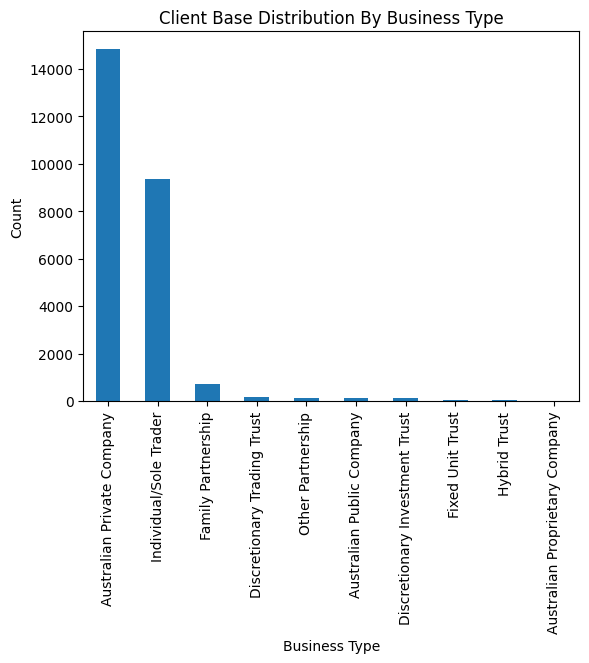

In [4]:
# table distribution of entity_type
clients_eda_df['entity_type'].value_counts().plot(kind='bar')
plt.title('Client Base Distribution By Business Type')
plt.xlabel('Business Type')
plt.ylabel('Count')

In [5]:
default_proportions = clients_eda_df.groupby(['entity_type', 'payment_code']).size().unstack().fillna(0)

default_proportions

payment_code,DEFAULT,PAYMENT
entity_type,,
Australian Private Company,1217.0,13610.0
Australian Proprietary Company,0.0,4.0
Australian Public Company,16.0,112.0
Discretionary Investment Trust,23.0,101.0
Discretionary Trading Trust,21.0,166.0
Family Partnership,33.0,703.0
Fixed Unit Trust,0.0,32.0
Hybrid Trust,2.0,30.0
Individual/Sole Trader,901.0,8453.0


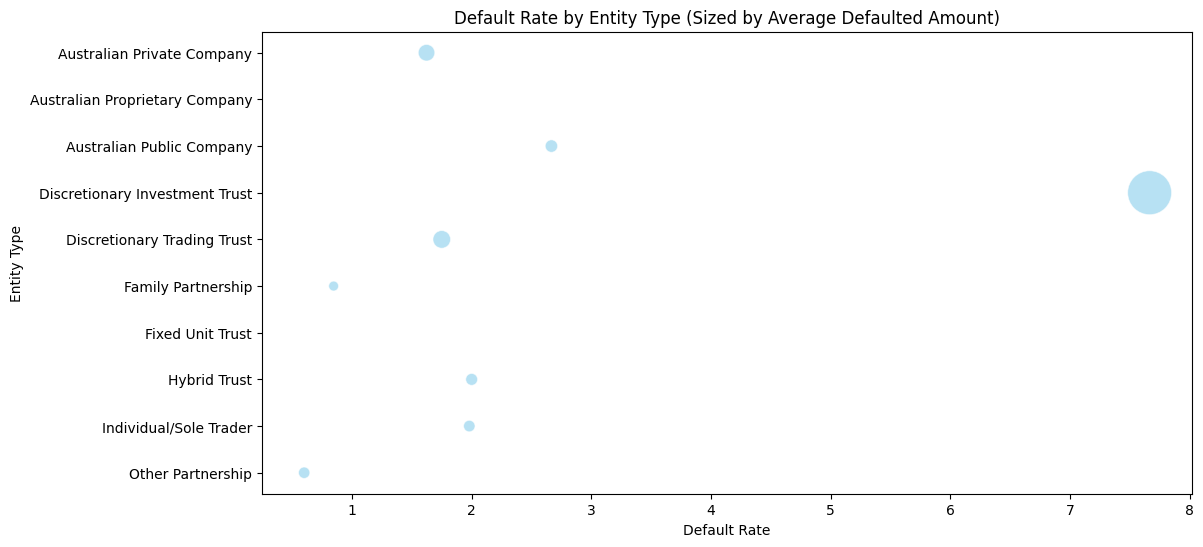

In [6]:
# Bubble chart of default rate by entity type ans size of client base
client_counts = clients_eda_df.groupby('entity_type')['client_id'].nunique()
# average payment where not default
# median_defaulted_payment = clients_payment_df[clients_payment_df['payment_code']=='DEFAULT'].groupby('entity_type')['payment_amt'].median()
average_defaulted_payment = clients_payment_df[clients_payment_df['payment_code']=='DEFAULT'].groupby('entity_type')['payment_amt'].mean()
# average payment amount (excluding defaults) of each entity type



plt.figure(figsize=(12, 6))
sns.scatterplot(x=default_proportions['DEFAULT'] / client_counts, y=default_proportions.index, size=average_defaulted_payment, sizes=(50, 1000), legend=False, color='skyblue', alpha=0.6)
plt.title('Default Rate by Entity Type (Sized by Average Defaulted Amount)')
plt.xlabel('Default Rate')
plt.ylabel('Entity Type')
plt.show()

In [7]:
print(average_defaulted_payment.sort_values(ascending=False))

entity_type
Discretionary Investment Trust    4946.242174
Discretionary Trading Trust        877.671905
Australian Private Company         785.943361
Australian Public Company          485.676250
Hybrid Trust                       450.000000
Individual/Sole Trader             428.108923
Other Partnership                  420.988333
Family Partnership                 341.464848
Name: payment_amt, dtype: float64


In [8]:
default_proportions['DEFAULT'] / client_counts

entity_type
Australian Private Company        1.622667
Australian Proprietary Company    0.000000
Australian Public Company         2.666667
Discretionary Investment Trust    7.666667
Discretionary Trading Trust       1.750000
Family Partnership                0.846154
Fixed Unit Trust                  0.000000
Hybrid Trust                      2.000000
Individual/Sole Trader            1.980220
Other Partnership                 0.600000
dtype: float64

In [9]:
# Chi-squared test for independence between entity type and payment code
contingency_table = pd.crosstab(clients_eda_df['entity_type'], clients_eda_df['payment_code'])
chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)
print(f"Chi-squared statistic: {chi2_stat}, p-value: {p_value}, degrees of freedom: {dof}")

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant association between entity type and payment code.")
else:
    print("Fail to reject the null hypothesis: There is no significant association between entity type and payment code.")

Chi-squared statistic: 57.04742379554983, p-value: 4.948944963368191e-09, degrees of freedom: 9
Reject the null hypothesis: There is a significant association between entity type and payment code.


**Based on factors of default counts, average defaulted payment, and default rate, below is an analysis of default risks by entity type:**


| Entity Type                    | Default Count | Average Defaulted Payment | Default Rate | Risk Level |
|---------------------------------|---------------|----------------------------|--------------|------------|
| Discretionary Investment Trust  | 23            | $4946.24                    | 7.67         | Critical   |
| Discretionary Trading Trust     | 21            | $877.67                     | 1.75         | High       |
| Australian Private Company      | 1217          | $785.94                     | 1.62         | Critical   |
| Australian Public Company       | 16            | $485.67                     | 2.67         | Medium     |
| Hybrid Trust                    | 2             | $450.00                     | 0.06         | Low        |
| Individual/Sole Trader          | 901           | $428.11                     | 1.98         | High       |
| Other Partnership               | 6             | $420.00                     | 0.60         | Low        |
| Family Partnership              | 33            | $341.46                     | 0.85         | Medium     |
| Australian Proprietary Company  | 0             | $0.00                       | 0.00         | Low        |
| Fixed Unit Trust                | 0             | $0.00                       | 0.00         | Low        |

Critical Risk:

- Discretionary Investment Trust and Australian Private Company are classified as Critical Risk. Both of these entity types have a high number of defaults, with Australian Private Company having an exceptionally high default count (1217). Despite Discretionary Investment Trust having fewer defaults, the average defaulted payment is extremely high (4946.24), suggesting that the amounts defaulted are significant and require serious attention.


High Risk:

- Discretionary Trading Trust and Individual/Sole Trader fall into the High Risk category. These entities show high default counts and/or default rates and/or default amounts. While their defaults stats are lower than those in the Critical Risk group, they still indicate substantial risk.

Medium Risk:
- Australian Public Company an has a default rate of 2.67, which is a big concern, but has a relatively low default count. Family Partnership has a lower average default amount but has quite many default cases.

Low Risk:

- Hybrid Trust, Other Partnership, Family Partnership, Australian Proprietary Company, and Fixed Unit Trust are categorized as Low Risk. These entities exhibit low default counts (mostly in single digits or none at all), coupled with very low default rates. The average defaulted payment amounts are also on the lower end for these entities, with the highest being 450.00 for Hybrid Trust, which further suggests lower overall risk.

- The Australian Proprietary Company and Fixed Unit Trust have 0 defaults, contributing to their low-risk classification.

### By Entity Age

In [10]:
print(clients_eda_df['entity_age'].describe())

count    25559.000000
mean        15.829258
std          5.629679
min          7.000000
25%         11.000000
50%         14.000000
75%         20.000000
max         26.000000
Name: entity_age, dtype: float64


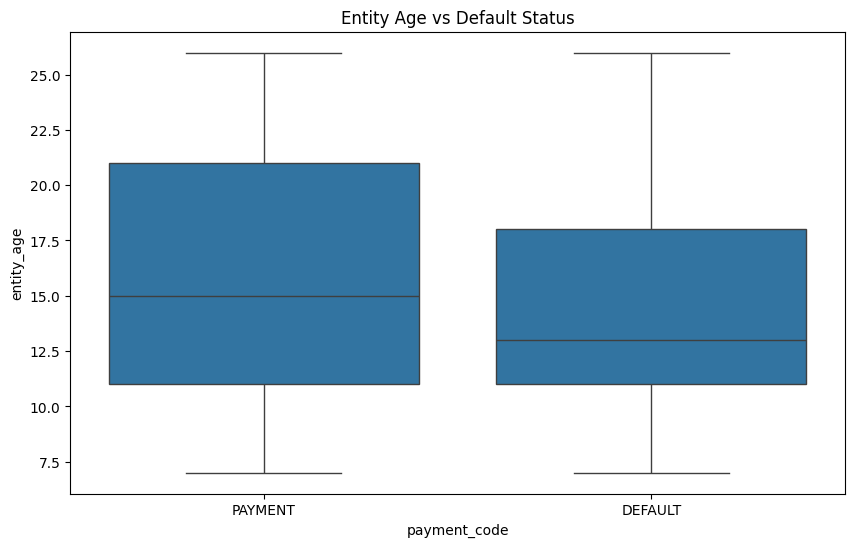

In [11]:
# Entity age vs default
plt.figure(figsize=(10, 6))
sns.boxplot(x='payment_code', y='entity_age', data=clients_eda_df)
plt.title('Entity Age vs Default Status')
plt.show()

- The boxplot shows that clients who default tend to be slightly older than those who don’t. The median entity age for defaulting clients is closer to 15 years, while non-default clients tend to have a median age closer to 12-13 years.

- Both groups have similar interquartile ranges (the spread between the 25th and 75th percentiles), suggesting that the variation in entity age among both defaulting and non-defaulting clients is similar.

- The outliers in the default group (especially at higher ages, around 22-25 years) may suggest that older entities occasionally default more significantly than the typical trend, possibly due to market saturation, increased debt, or changes in business operations.

In [12]:
# t-test for the effect of entity age between default and non-default clients
default_clients = clients_eda_df[clients_eda_df['payment_code'] == 'DEFAULT']['entity_age']
non_default_clients = clients_eda_df[clients_eda_df['payment_code'] == 'PAYMENT']['entity_age']
t_stat, p_value = ttest_ind(default_clients, non_default_clients)[:2]
print(f"T-test statistic: {t_stat:.10f}, p-value: {p_value:.10f}")
# Interpret the p-value
if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference in entity age between default and non-default clients.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in entity age between default and non-default clients.")


T-test statistic: -8.7023156833, p-value: 0.0000000000
Reject the null hypothesis: There is a significant difference in entity age between default and non-default clients.


The t-test results indicate that there is a significant difference in entity age between default and non-default clients, with a p-value less than 0.05. This suggests that the age of the entity may be a factor in predicting default status. Let's look more closely into the age distribution of default clients.

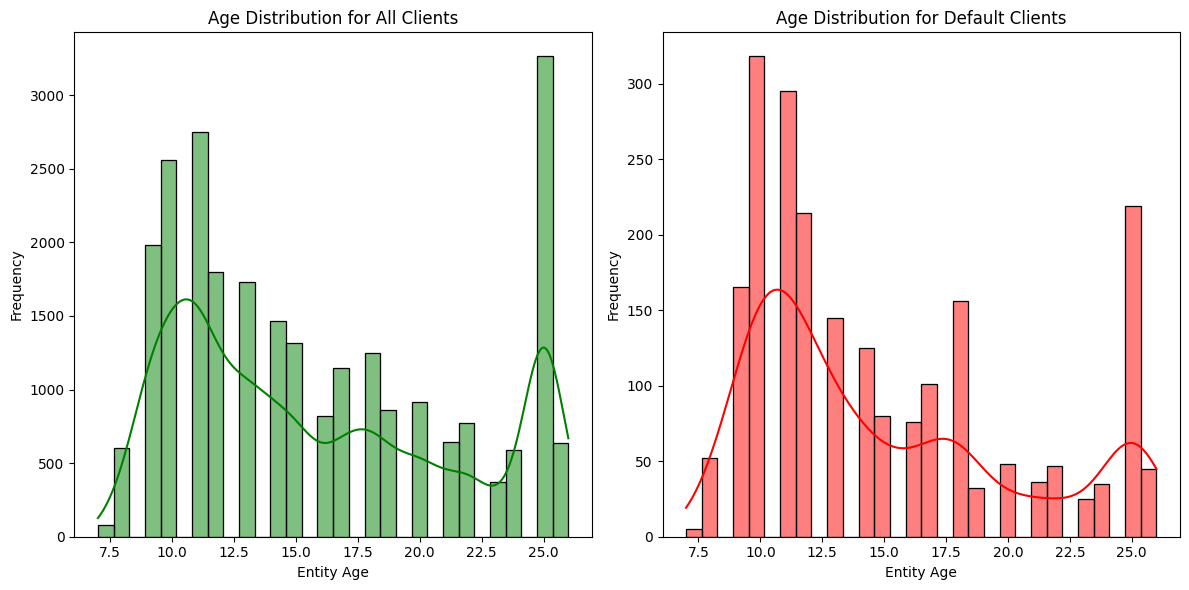

In [13]:
# histogram of entity age for all clients and default clients
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(clients_eda_df['entity_age'], bins=30, color = "green", kde=True)
plt.title('Age Distribution for All Clients')
plt.xlabel('Entity Age')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(clients_eda_df[clients_eda_df['payment_code'] == 'DEFAULT']['entity_age'], bins=30, color = "red", kde=True)
plt.title('Age Distribution for Default Clients')
plt.xlabel('Entity Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


- Since there are more clients around the 10-year AND 25 year age marks, there are naturally more defaults recorded in that age group.

This does not necessarily mean that younger businesses are at a higher rate of default. It just means there are more clients in that age bracket, increasing the chances of recording defaults in that group.

To better assess default-prone clients, it might be more useful to look at the default rate within each age group.

Top 5 default rate by clients' age 
entity_age
18    0.124800
10    0.124073
12    0.119154
11    0.107234
16    0.093023
Name: payment_code, dtype: float64


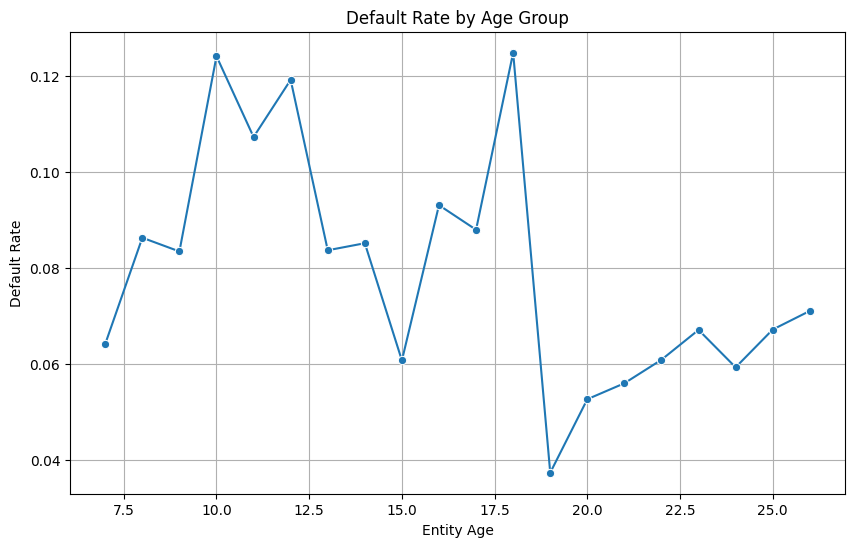

In [14]:
default_rate_by_age = clients_eda_df.groupby('entity_age')['payment_code'].apply(lambda x: (x == 'DEFAULT').sum() / len(x))
print(f"Top 5 default rate by clients' age \n{default_rate_by_age.sort_values(ascending=False).head(5)}")

plt.figure(figsize=(10, 6))
sns.lineplot(x=default_rate_by_age.index, y=default_rate_by_age.values, marker='o')
plt.title('Default Rate by Age Group')
plt.xlabel('Entity Age')
plt.ylabel('Default Rate')
plt.grid()
plt.show()

- Younger businesses exhibit the highest default rates, particularly between year 17-18 and 10-12.

- This suggests that businesses in the early-to-middle stage of their lifecycle are more vulnerable to default, possibly due to growing pains, market pressures, or financial instability. 

-> Thus, focus on businesses around 10-18 years old for targeted risk mitigation strategies, as they show the highest likelihood of default.

### Multivariate Effect

#### Cross-tabulation of Entity Type and Age with Default Rates

We would look closer at the default rates for each entity type at different age to gather more detailed insights for each client category.

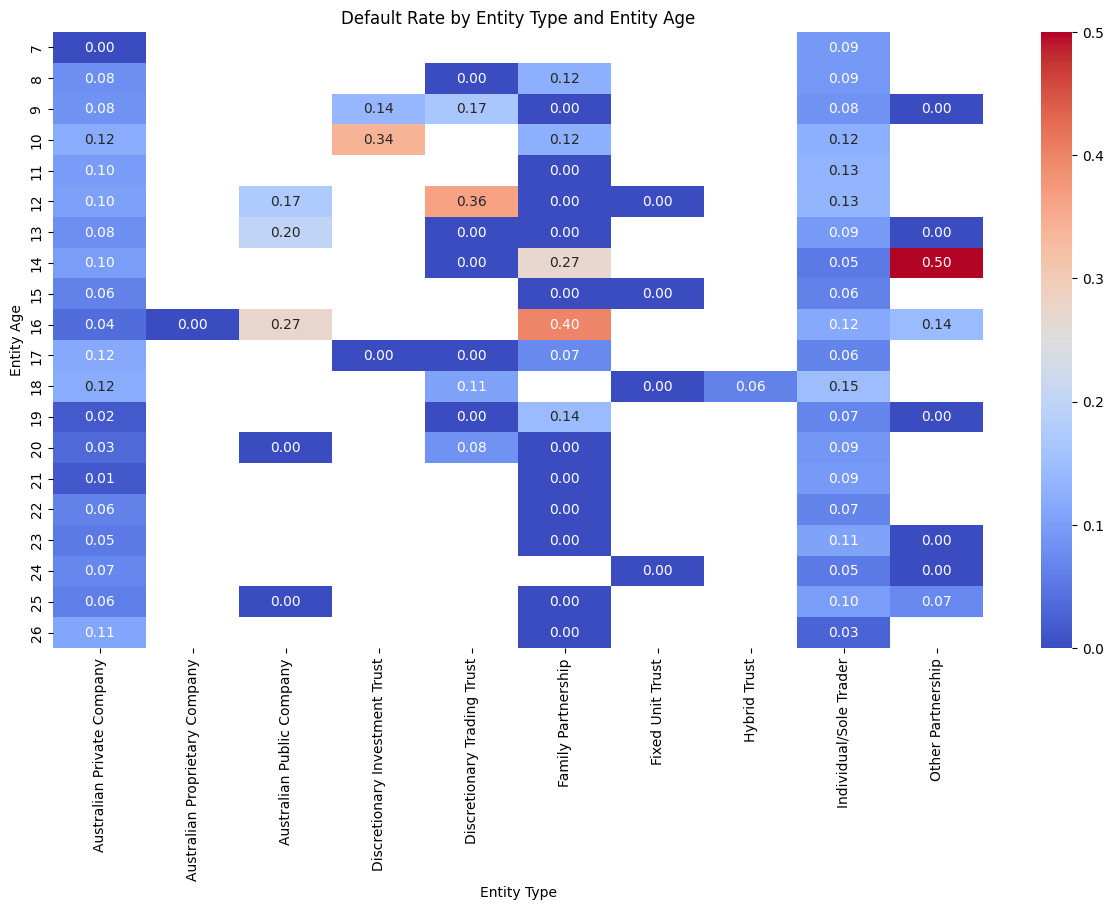

In [15]:
# Grouping by both entity_type and entity_age to calculate default rates
default_rate_by_type_age = clients_eda_df.groupby(['entity_type', 'entity_age'])['payment_code'].apply(lambda x: (x == 'DEFAULT').sum() / len(x)).reset_index()

# Pivot the data for better visualization
pivot_table = default_rate_by_type_age.pivot_table(values='payment_code', index='entity_age', columns='entity_type', aggfunc='mean')


plt.figure(figsize=(15, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Default Rate by Entity Type and Entity Age")
plt.ylabel("Entity Age")
plt.xlabel("Entity Type")
# plt.xticks(rotation=45)
plt.show()


In general, the most common age of default-prone companies are around 16-17 across many establishment types. This is consistent with the finding above about the relationship between clients' age and default rate.

- Australian Private Company: Defaults peak at ages 10, 12, and 17, with a decrease in older ages, suggesting higher risk in these early years.

- Australian Proprietary Company & Fixed Unit Trust: Default rate is flat.

- Australian Public Company: Moderate default rates around age 12-13, but a spike at age 16 (0.27).

- Discretionary Investment Trust: High default rates at ages 9-10, particularly at age 10 (0.34).

- Discretionary Trading Trust: A peak at age 12 (0.36), otherwise low default rates.

- Family Partnership: The highest default rate at age 16 (0.40) and age 14 (0.27), indicating significant vulnerability at this age range.

- Hybrid Trust: Very low default rate only recorded for companies at age 18.

- Individual/Sole Trader: Peaks at ages 10-12 and 16-18, particularly at age 18.

- Other Partnership: Very low default rates across all ages, with most cases recorded at age 14.

#### Pearson Correlation Analysis

In [16]:
# one hot encoding entity_type
clients_eda_df = pd.get_dummies(clients_eda_df, columns=['entity_type'], dtype='int')
clients_eda_df['default'] = (clients_eda_df['payment_code'] == 'DEFAULT').astype(int)
clients_eda_df = clients_eda_df.drop(columns=['payment_code', 'client_id'])
clients_eda_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25559 entries, 0 to 25558
Data columns (total 12 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   entity_age                                  25559 non-null  int64
 1   entity_type_Australian Private Company      25559 non-null  int64
 2   entity_type_Australian Proprietary Company  25559 non-null  int64
 3   entity_type_Australian Public Company       25559 non-null  int64
 4   entity_type_Discretionary Investment Trust  25559 non-null  int64
 5   entity_type_Discretionary Trading Trust     25559 non-null  int64
 6   entity_type_Family Partnership              25559 non-null  int64
 7   entity_type_Fixed Unit Trust                25559 non-null  int64
 8   entity_type_Hybrid Trust                    25559 non-null  int64
 9   entity_type_Individual/Sole Trader          25559 non-null  int64
 10  entity_type_Other Partnership     

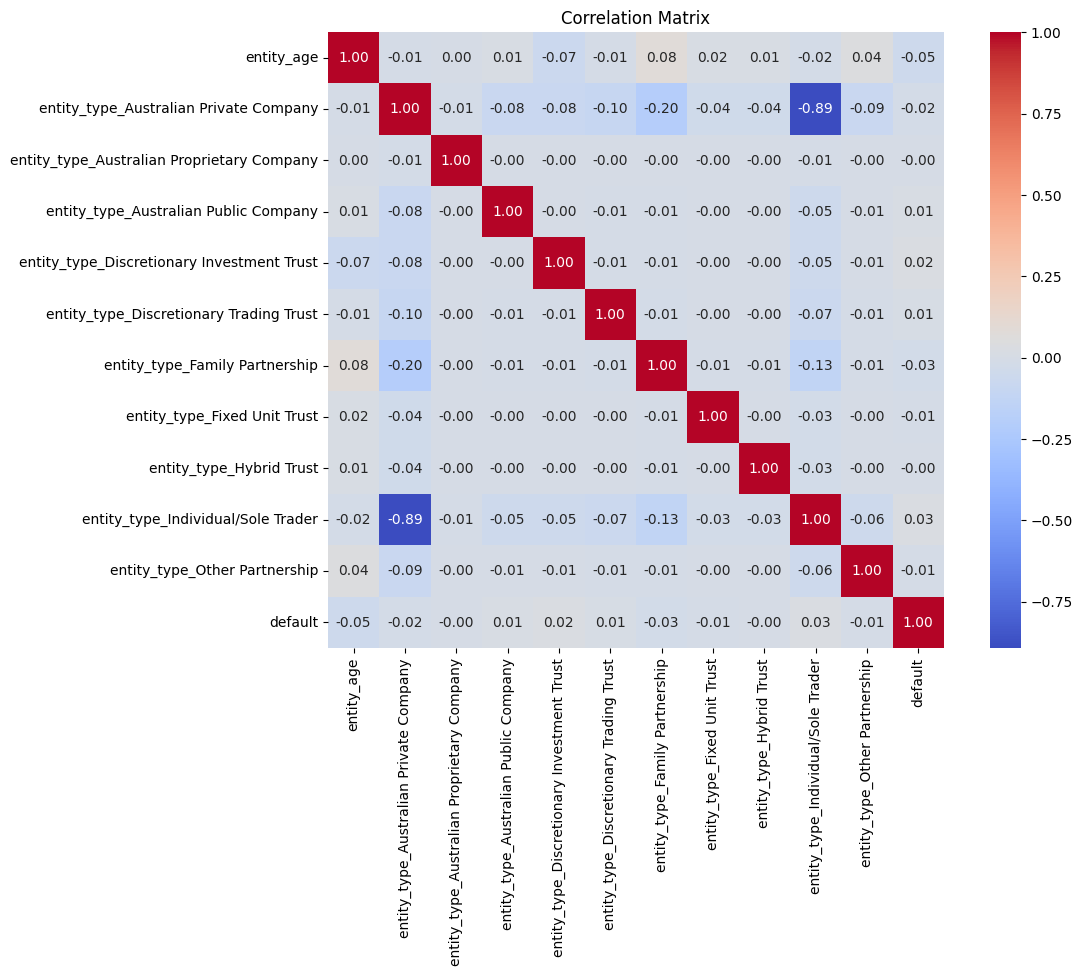

In [17]:
# correlation matrix
plt.figure(figsize=(12, 8))
corr = clients_eda_df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()




There seem to be very small linear correlations between all features and the target variable `default`. This indicate that the relationship between the features and the target might be non-linear.

In such cases, non-linear algorithms like KNN, decision trees, random forests, or gradient boosting models might capture the patterns better for predicting default-prone customers.

#### Feature Importance in predicting Default payments from Random Forest Model

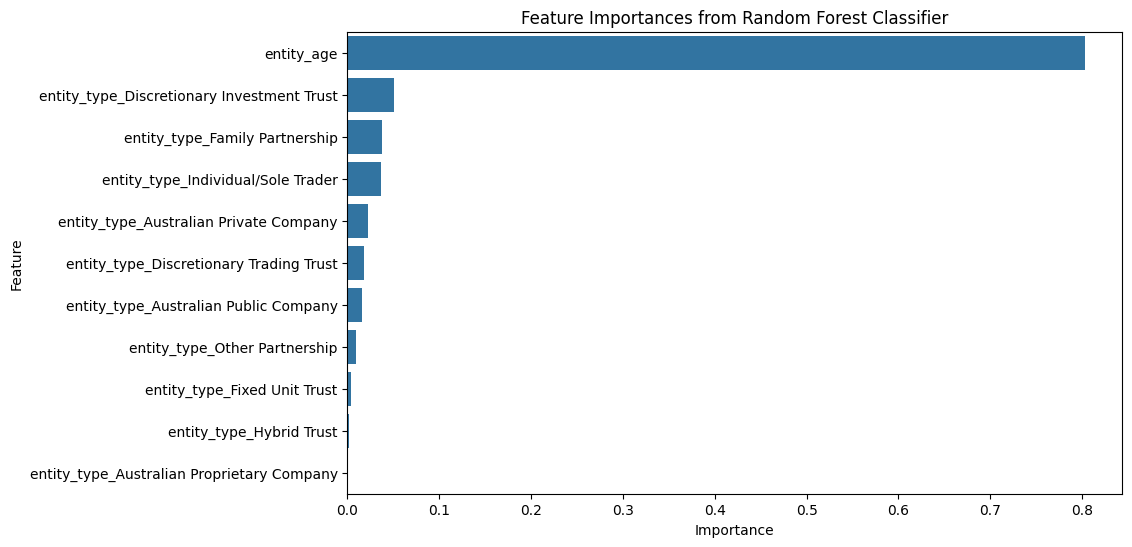

In [18]:
# Define features and target variable
y_fi = clients_eda_df['default']
X_fi = clients_eda_df.drop(columns=['default'])
# Split the data into training and testing sets
X_train_fi, X_test_fi, y_train_fi, y_test_fi = train_test_split(X_fi, y_fi, test_size=0.2, random_state=42, stratify=y_fi)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_fi, y_train_fi)

feature_importances = pd.DataFrame({'Feature': X_fi.columns, 'Importance': rf.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances from Random Forest Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Entity's age is the most important company's characteristic used by the model to predict default payments.

## Predictive Modelling: Detecting future default-prone customers

Since we are aiming to avoid default-prone clients, recall is critical because you want to identify as many default-prone clients as possible. However, this might lead to some false positives, where non-defaulting clients are flagged as default-prone.
However, falsely flagging a client as default-prone could result in a loss of revenue. So it's crucial to carefully balance the false positives and false negatives with `F1` metric.


In [19]:
train_df = clients_eda_df.copy()

y = train_df['default']
X = train_df.drop(columns=['default'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data Resampling

Text(0, 0.5, 'Count')

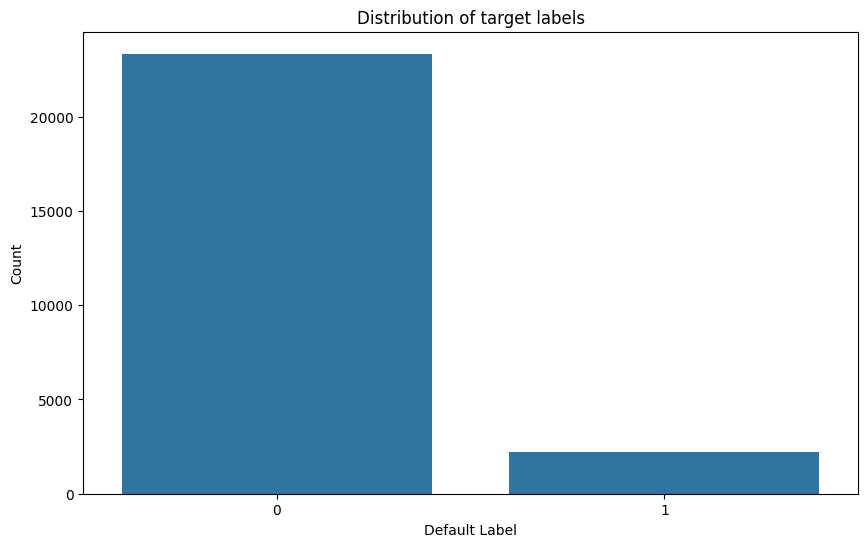

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='default', data=train_df)
plt.title('Distribution of target labels')
plt.xlabel('Default Label')
plt.ylabel('Count')

Here, we see that the default cases are under represented compared to non-default cases. Class imbalance can significantly impact the performance of predictive models, especially when we're trying to predict rare events like defaults. Models trained on imbalanced datasets tend to be biased towards the majority class (non-default), and they may struggle to correctly predict the minority class (defaults).

Thus, I would use the **Under Sampling** technique to undersample the majority class (non-default) by randomly reducing the number of non-default instances. 

In [21]:
# under sampling the majority class
rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

y_rus.value_counts()

default
0    1772
1    1772
Name: count, dtype: int64

### Logistic Regression

In [22]:
# logistic regression
from sklearn.linear_model import LogisticRegression

# Define the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_rus, y_rus)
log_reg_y_pred = log_reg.predict(X_test)
# log_reg_y_pred_proba = log_reg.predict_proba(X_test)[:, 1]
log_reg_recall = recall_score(y_test, log_reg_y_pred)
log_reg_precision = precision_score(y_test, log_reg_y_pred)
log_reg_f1 = f1_score(y_test, log_reg_y_pred)
log_reg_avg_precision = average_precision_score(y_test, log_reg_y_pred)

print(f"Logistic Regression Recall Score: {log_reg_recall}")
print(f"Logistic Regression Precision Score: {log_reg_precision}")
print(f"Logistic Regression F1 Score: {log_reg_f1}")
print(f"Logistic Regression Average Precision Score: {log_reg_avg_precision}")


Logistic Regression Recall Score: 0.6263982102908278
Logistic Regression Precision Score: 0.10075566750629723
Logistic Regression F1 Score: 0.1735895846249225
Logistic Regression Average Precision Score: 0.09578140141449588


### Random Forest Classifier

In [23]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, 30],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10],
    'bootstrap': [True]
}

rf = RandomForestClassifier(random_state=42)

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                                scoring="f1", cv=10, refit=True, random_state=42, n_jobs=-1)

random_search.fit(X_rus, y_rus)

rf_best = random_search.best_estimator_

rf_y_pred = rf_best.predict(X_test)

rf_recall = recall_score(y_test, rf_y_pred)
rf_precision = precision_score(y_test, rf_y_pred)
rf_f1 = f1_score(y_test, rf_y_pred)
r1_avg_precision = average_precision_score(y_test, rf_y_pred)

print(f"Random Forest Recall Score On Testing Set: {rf_recall}")
print(f"Random Forest Precision Score On Testing Set: {rf_precision}")
print(f"Random Forest F1 Score On Testing Set: {rf_f1}")
print(f"Random Forest Average Precision Score On Testing Set: {r1_avg_precision}")


Random Forest Recall Score On Testing Set: 0.7427293064876958
Random Forest Precision Score On Testing Set: 0.10807291666666667
Random Forest F1 Score On Testing Set: 0.18868996874111962
Random Forest Average Precision Score On Testing Set: 0.10276501008286859


### XGBoost Classifier

In [24]:
# Create params grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10]
}

# Initialize the XGBoost Regressor
xg_classifier = XGBClassifier(random_state=42)

# Initialize the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xg_classifier, param_distributions=param_grid, 
                                    cv=5, scoring="f1", refit=True, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_rus, y_rus)

# Get the best parameters
xgb_best = random_search.best_estimator_

# Make predictions
xgb_y_pred = xgb_best.predict(X_test)

xgb_recall = recall_score(y_test, xgb_y_pred)
xgb_precision = precision_score(y_test, xgb_y_pred)
xgb_f1 = f1_score(y_test, xgb_y_pred)
xgb_avg_precision = average_precision_score(y_test, xgb_y_pred)

print(f"XGBoost Recall Score: {xgb_recall}")
print(f"XGBoost Precision Score: {xgb_precision}")
print(f"XGBoost F1 Score: {xgb_f1}")
print(f"XGBoost Average Precision Score: {xgb_avg_precision}")

XGBoost Recall Score: 0.6577181208053692
XGBoost Precision Score: 0.11102719033232629
XGBoost F1 Score: 0.189983844911147
XGBoost Average Precision Score: 0.10295417244846641


The performance metrics for all 3 models on the testing set show a significant imbalance between recall and precision when predicting defaults.

Metrics Analysis:
- Recall: The models are doing a fairly good job at catching most of the default-prone clients, as around 62%-75% of actual defaults are correctly identified (True Positives). However, this comes at the cost of precision.

- Precision: The models are flagging many non-default clients as default-prone (False Positives). Only about 10%-11% of the clients that the model flagged as default-prone actually ended up being default-prone. This can result in revenue loss from unnecessary interventions or actions aimed at clients who are not actually at risk.

- F1-Score (0.19): The F1-score is quite low, suggesting that the balance between precision and recall is poor. This is expected since the model is sacrificing precision to get better recall.

<br/>

> CONCLUSION: While the recall score is good, the low precision and F1 score suggest that building predictive models from the current features set is not effective for our goal.

>  We should not deploy these for usage.